## Training for ResNet18

*if using google drive, run following two cells*

In [ ]:
import os
from google.colab import drive
drive.mount('/content/drive')
project_dir = '/content/drive/MyDrive/master_courses/BIDH5001 Capstone/Project/\
deep-classification'
os.chdir(project_dir)

In [ ]:
%pip install pydicom    

imports, initiating dataloaders

In [1]:
# imports
import datetime
import time
import warnings
import torch
import config
from dataio.dataloader import create_dataloader
from networks.resnet_classifier import resnet18_classifier
from training.utility import ProgressBar
from training.evaluation import AccuracyEvaluator, LossEvaluator
from training.early_stopper import ValLoss as EarlyStopper

# whenever possible, use cuda instead of cpu
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
if torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")
    warnings.warn("cuda is using CPU, this can be very slow")


In [29]:
# paths to save and load state dictionary
import os
import re

load_sd = True
save_sd = True

bin_path = "bin"
assert os.path.isdir(bin_path)
sd_files = [
    filename for filename in os.listdir(bin_path)
    if re.match(r'res18_state_[0-9]{2}-[0-9]{2}\.pkl', filename)]
sd_files.sort(reverse=True)
sd_load_filename = sd_files[0] if len(sd_files) > 0 else None
sd_save_filename = f"res18_state_{datetime.datetime.now().strftime('%m-%d')}.pkl"
sd_load_path = os.path.join(bin_path, sd_load_filename) \
    if sd_load_filename is not None else None
sd_save_path = os.path.join(bin_path, sd_save_filename)

preparing the training:
1. read dicoms and labels from configuration and tracking table, initiate dataloaders
2. set up criterions and optimizers, training parameters

In [2]:
# reading from configurations
dicoms = config.tracking_table['dicom_path'].to_list()
labels = config.tracking_table['label'].astype('int16').to_list()

# initiate the dataloaders
dataloader_dict = create_dataloader(
    dicoms, labels,
    dicom_dir = config.dicom_dir,
    batch_size = 1,
    validation_size = config.validation_size,
    test_size = config.test_size
)
training_dataloader, validation_dataloader, test_dataloader = \
    (dataloader_dict.get(key) for key in ('training_dataloader', 'validation_dataloader', 'test_dataloader'))

In [9]:
# some settings, move to config in future
learning_rate = 0.0001 # 0.00005, originally without lr scheduler
n_epoches = 15
starting_epoch = 31

# the classifier model
model = resnet18_classifier
# load state dict into 
if load_sd and sd_load_path:
    state_dict = torch.load(sd_load_path)
    model.load_state_dict(state_dict)

# optimizers
loss_function = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
# scheduler = torch.optim.lr_scheduler.OneCycleLR(
#     optimizer, max_lr=learning_rate,
#     steps_per_epoch=len(training_dataloader), epochs=n_epoches,
#     )
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, 'min', factor=0.25, patience=1,
    threshold=0.05, threshold_mode='rel',
    min_lr = learning_rate / 32,
    cooldown=7,
)
earlystopper = EarlyStopper(tolerance=4, target=0.25)

# accuracy and loss evaluators
training_loss = LossEvaluator(loss_function)
validation_loss = LossEvaluator(loss_function)
validation_accuracy = AccuracyEvaluator()

In [11]:
# to continue training for n_epoches
n_epoches = 10

training for resnet18 image quality classifier

In [12]:
# evaluators for training/validation loss and accuracy
# training_loss = LossEvaluator(loss_function)
# validation_loss = LossEvaluator(loss_function)
# validation_accuracy = AccuracyEvaluator()

# training epoches loop
for epoch in range(n_epoches):
    current_epoch = epoch + 1 + starting_epoch
    print(f'epoch # {current_epoch}')
    progress = ProgressBar(len(training_dataloader) + len(validation_dataloader))
    epoch_start_time = time.time()
    # training network
    for images, labels in training_dataloader:
        images = images.to(torch.float32)
        labels = labels.to(torch.float32)
        labels_pred = model(images)
        # train loss
        loss_training = loss_function(labels_pred, labels)
        training_loss.append_loss(loss_training.item())
        # backpropagation
        optimizer.zero_grad()
        loss_training.backward()
        optimizer.step()
        progress.step()
    # validating network
    for images, labels in validation_dataloader:
        images = images.to(torch.float32)
        labels = labels.to(torch.float32)
        labels_pred = model(images)
        loss_validation = loss_function(labels_pred, labels)
        validation_loss.append_loss(loss_validation.item())
        validation_accuracy.append(labels_pred, labels)
        progress.step()
    epoch_end_time = time.time()
    print(
        f'train loss: {training_loss}  \
        validation loss: {validation_loss}  \
        validation accuracy: {validation_accuracy}')
    print(
        f'precision: {round(validation_accuracy.precision(), 3)}  \
        recall: {round(validation_accuracy.recall(), 3)}  \
        f1: {round(validation_accuracy.f1(), 3)}')
    # step scheduler
    scheduler.step(validation_loss.value())
    # the evaluators have __str__
    print(
        f'duration: {round(epoch_end_time - epoch_start_time, 2)} s  \
        learning rate: {round(scheduler.get_last_lr()[0], 9)}')
    # step early stopper
    earlystopper.step(validation_loss.value())
    print('-'*75)
    if earlystopper.stop():
        print('early stopper triggered, break')
        break
    # reset pred and actual labels after each epoch
    validation_accuracy.reset_labels()

# update the starting epoch number
starting_epoch += epoch
# save model state_dicts to target path
if save_sd:
    torch.save(model.state_dict(), sd_save_path)
    print(f'state dict saved to path: {sd_save_path}')

epoch # 15
train loss: 0.008          validation loss: 0.543          validation accuracy: 85.54 %
precision: 1.0,            recall: 0.6190476190476191,              f1: 0.7647058823529412
duration: 31.1 s          learning rate: 6.25e-06
--------------------------------------------------
epoch # 16
train loss: 0.007          validation loss: 0.546          validation accuracy: 85.71 %
precision: 1.0,            recall: 0.6363636363636364,              f1: 0.7777777777777778
duration: 30.55 s          learning rate: 6.25e-06
--------------------------------------------------
epoch # 17
train loss: 0.007          validation loss: 0.549          validation accuracy: 85.87 %
precision: 1.0,            recall: 0.6521739130434783,              f1: 0.7894736842105263
duration: 30.86 s          learning rate: 6.25e-06
--------------------------------------------------
epoch # 18
train loss: 0.007          validation loss: 0.553          validation accuracy: 86.01 %
precision: 1.0,           

In [32]:
len(validation_loss.labels_actual_raw)

980

In [15]:
import datetime
state_dict_save_path = f"bin/res18_state_{datetime.datetime.now().strftime('%m-%d')}"
state_dict_save_path

'bin/res18_state_03-28'

In [16]:
import datetime
state_dict_save_path = f"bin/res18_state_{datetime.datetime.now().strftime('%m-%d')}.pkl"
torch.save(model.state_dict(), state_dict_save_path)

In [7]:
validation_accuracy._tfpn()

(0, 0, 13, 0)

In [8]:
validation_accuracy.labels_actual

[tensor(2),
 tensor(2),
 tensor(1),
 tensor(1),
 tensor(1),
 tensor(1),
 tensor(1),
 tensor(1),
 tensor(1),
 tensor(1),
 tensor(1),
 tensor(1),
 tensor(1)]

In [14]:
sum([len(training_dataloader), len(validation_dataloader), len(test_dataloader)])

140

In [16]:
validation_pred_labels = [torch.argmax(lbl).item() for lbl in validation_accuracy.labels_pred_raw]
validation_actual_labels = [torch.argmax(lbl).item() for lbl in validation_accuracy.labels_actual_raw]
sum(validation_pred_labels)

1

In [23]:
n_total = len(validation_actual_labels)
n_correct = 0
for pred_label, actual_label in zip(validation_pred_labels, validation_actual_labels):
    if pred_label == actual_label:
        n_correct += 1
n_correct / n_total

0.8520710059171598

In [9]:
validation_accuracy.labels_pred_raw[:3]

[tensor([ 0.5962, -0.0964, -1.0432], grad_fn=<UnbindBackward0>),
 tensor([ 0.5093,  0.1406, -0.8743], grad_fn=<UnbindBackward0>),
 tensor([ 1.3376, -0.6933, -1.3025], grad_fn=<UnbindBackward0>)]

In [7]:
validation_accuracy.accuracy()

0.8520710059171598

calculate test set loss and accuracy

In [5]:
# evaluators for test loss and accuracy
test_loss = LossEvaluator(criterion=loss_function)
test_accuracy = AccuracyEvaluator()

# iterate through test dataloader
for images, labels in test_dataloader:
    images = images.to(torch.float32)
    labels = labels.to(torch.float32)
    labels_pred = model(images)
    loss = loss_function(labels_pred, labels)
    test_loss.append_loss(loss)
    test_accuracy.append(labels_pred, labels)
print(f'test loss: {test_loss}\
      test accuracy: {test_accuracy}')


test loss: 0.188      test accuracy: 84.37 %


In [21]:
# function shows saliency map
def calculate_saliency_map(model, image, target_class):

    """
    Calculates the saliency map for a given image and target class.

    Args:
    model: A PyTorch model.
    image: A PyTorch tensor containing the image.
    target_class: The target class.

    Returns:
    numpy array containing the saliency map.
    """

    # Forward pass the image through the model.
    output = model(image)
    # Get the gradient of the output with respect to the input image.
    # gradient = torch.autograd.grad(output[0][target_class], image[0])
    gradient = torch.autograd.grad(
        output, image, grad_outputs=target_class.view(1,-1),
        allow_unused=True)[0][0]
    # Calculate the absolute value of the gradient.
    # saliency_map = torch.abs(gradient)
    saliency_map = torch.norm(gradient)
    # Normalize the saliency map.
    saliency_map = saliency_map / torch.max(saliency_map)
    saliency_map_np = saliency_map.detach().numpy()
    return saliency_map_np

In [32]:
gradient = torch.autograd.grad(output, image, grad_outputs)

tensor([[-1.6480, -2.6376,  3.8333]], grad_fn=<AddmmBackward0>)

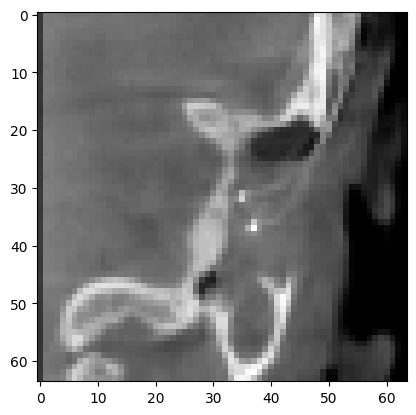

In [15]:
import matplotlib.pyplot as plt
image = images_val[0][0]
plt.imshow(image, cmap='binary_r')

In [ ]:
import tempfile
for images in test_dataloader.view()

In [40]:
len(validation_accuracy.labels_actual_raw)

678

## Appendix
additional details about the model

structure of the resnet_18 model

In [6]:
model

ResNet(
  (conv1): Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  